Partie 1
#Chargement des données 

In [247]:
import pandas as pd
import re

def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'

# Patterns for extracting train and test data
train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'

# Extracting train and test data
rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

print(len(train_df))
print(len(test_df)) 


104
104


Partie 2

##Apprentissage sur train

In [248]:
import numpy as np

def perceptron_batch(training_features, training_labels, epochs, learning_rate):

    # Initialisation des poids
    weights = np.zeros(training_features.shape[1] + 1)
    
    # Entraînement
    for _ in range(epochs):
        # Initialisation du vecteur de mise à jour pour cette époque
        update = np.zeros(training_features.shape[1] + 1)
        
        for inputs, label in zip(training_features, training_labels):
            # Calcul de la prédiction
            activation = np.dot(inputs, weights[1:]) + weights[0]
            if activation >= 0:
                prediction = 1
            else:
                prediction = -1
            
            # Accumulation de la mise à jour basée sur l'erreur
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        
        # Mise à jour des poids à la fin de l'époque
        weights += update
    
    return weights

# Préparation des données
# Supposons que train_df est déjà défini et mélangé
# Convertir les étiquettes 'R' et 'M' en valeurs numériques -1 et 1
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparation des caractéristiques et des étiquettes
train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

# Entraînement du perceptron
weights = perceptron_batch(train_features, train_labels,22000,0.001)

Calcul de Ea et de Eg

In [249]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1

# Fonction pour calculer la précision
def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

# Convertir les étiquettes de l'ensemble de test en valeurs numériques -1 et 1
# test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)

# Séparer les caractéristiques et les étiquettes de l'ensemble de test
test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values

# Calculer la précision sur l'ensemble d'entraînement et de test
training_accuracy = calculate_accuracy(train_features, train_labels, weights)
testing_accuracy = calculate_accuracy(test_features, test_labels, weights)

# Calculer les erreurs d'apprentissage (Ea) et de généralisation (Eg)
Ea = 1 - training_accuracy
Eg = 1 - testing_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")

print("Les poids du perceptron",weights)

Erreur d'apprentissage (Ea) : 0.0
Erreur de généralisation (Eg) : 0.1923076923076923
Les poids du perceptron [-0.98       0.842751   2.1072314  0.3838012  1.1038062  0.7259872
  1.4434456 -0.6594728 -1.5828186  0.0899288  1.0787674  0.38768
  0.1341432  0.0255996  0.042866   0.5863472 -1.958266  -0.5572258
  2.0306202 -0.378772  -0.0970566 -0.3937258  0.5972566 -0.440081
  1.078278  -0.1139262 -0.1252908  0.1074978 -0.2024282 -0.19539
  2.048143  -3.0649636  2.3248804 -1.6053052  0.743006  -0.4041242
 -0.2133034 -0.3860196 -0.2090698  1.7067118 -1.526431   0.636046
 -0.140197  -0.1147842 -0.6595438  1.1983514  1.035655  -1.0689164
  2.105948   2.8900536 -1.2872816  0.5331192  0.5126696  0.30002
  0.825407  -0.1197684 -0.2328594 -0.544665   0.3433368 -0.1490698
 -0.1637436]


Fonction de stabilité

In [250]:
def calculate_stability(features, labels, weights):
    norm_w = np.linalg.norm(weights[1:])  # Calcul de la norme du vecteur de poids (sans le biais)
    stabilities = []
    for x, y in zip(features, labels):
        # Calcul de la marge fonctionnelle pour chaque exemple
        gamma = y * (np.dot(weights[1:], x) + weights[0]) / norm_w
        stabilities.append(gamma)
    return stabilities

# Calcul des stabilités pour l'ensemble de test
test_stabilities = calculate_stability(test_features, test_labels, weights)

# Afficher les stabilités des exemples de test
print(test_stabilities)




[0.07983593435332308, 0.05878370610762419, 0.12042269580186918, 0.007441359997917582, 0.00345330328702527, -0.02904303428410117, 0.02163424502250528, 0.04834832411075165, 0.11095867882739249, 0.08248702066140327, 0.13282763219599547, 0.16721869785067026, 0.12424440482863475, 0.06489550841873014, 0.05905422131395208, 0.06265733368466408, 0.03666161187972346, 0.1278733564913867, 0.09763893175005268, 0.056790219717957696, 0.03684822819133507, 0.10841419895433117, 0.05075649278576885, -0.016231327999166215, 0.1284684886715619, 0.030317984360207866, 0.16423151163533817, 0.14910719515134818, 0.0001425599546783556, 0.0537108194714951, -0.05801110738737808, 0.014626107736100307, 0.05748678622491089, -0.09055188285508863, -0.06331791162327202, 0.013523552468373657, -0.0433566282662845, 0.04896065254328488, 0.05331840266117704, 0.025140511904158554, -0.009165359455136931, -0.1098746183313325, 0.021359085205933614, 0.07343003608748103, 0.05128634944689478, 0.028314955270345752, -0.050381485980819

Graph

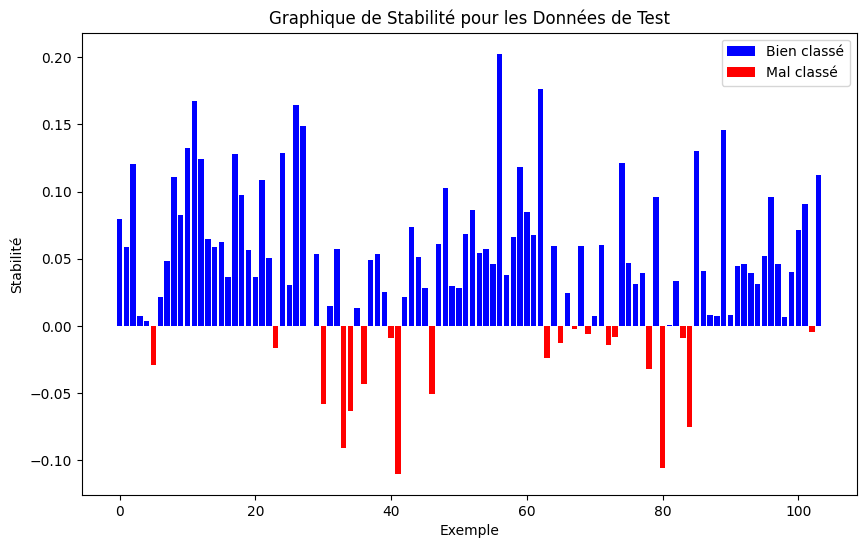

In [251]:
import matplotlib.pyplot as plt

def plot_stability(test_stabilities):
    # Définir les étiquettes pour les exemples bien classés et mal classés
    labels = ['Bien classé' if val > 0 else 'Mal classé' for val in test_stabilities]

    # Créer le graphique de stabilité
    plt.figure(figsize=(10, 6))

    # Barres pour les exemples bien classés
    plt.bar(range(len(test_stabilities)), [val if val > 0 else 0 for val in test_stabilities], 
            color='blue', label='Bien classé')

    # Barres pour les exemples mal classés
    plt.bar(range(len(test_stabilities)), [val if val < 0 else 0 for val in test_stabilities], 
            color='red', label='Mal classé')

    # Ajouter des légendes, des étiquettes et un titre
    plt.legend()
    plt.xlabel('Exemple')
    plt.ylabel('Stabilité')
    plt.title('Graphique de Stabilité pour les Données de Test')

    # Afficher le graphique
    plt.show()

plot_stability(test_stabilities)


Apprentissage sur "train et test"

Erreur d'apprentissage (Ea) : 0.09615384615384615
Erreur de généralisation (Eg) : 0.04807692307692313
Les poids du perceptron [-1.4060000e+00  2.7263776e+00  4.1823040e-01 -3.8693388e+00
  3.9574746e+00  3.3246620e-01  5.8838140e-01 -2.2077698e+00
 -1.5317032e+00  1.7412074e+00 -9.6917360e-01  2.3690888e+00
  5.8942460e-01 -4.5729000e-02 -3.4612540e-01  5.2547040e-01
 -5.0640340e-01 -1.2972996e+00  1.3238842e+00 -5.4880020e-01
  6.9305680e-01 -8.4891400e-01  1.2442930e+00 -9.2581080e-01
  1.9959568e+00 -8.2241560e-01 -3.5189720e-01  4.6993780e-01
 -3.1498480e-01 -1.6604240e-01  1.8712528e+00 -3.0814922e+00
  1.5055166e+00  2.3477480e-01 -9.9478860e-01  1.5755438e+00
 -1.7375118e+00 -3.5191160e-01  1.4334580e-01  1.3185718e+00
 -2.0211816e+00  5.7359440e-01  8.4407000e-02  5.5505540e-01
  5.0507020e-01  8.4901400e-01  9.5330800e-02  2.6794000e-03
  3.2833850e+00  3.7186640e+00 -2.8747132e+00  2.5147360e+00
  2.1065308e+00  1.4150502e+00  1.2052510e+00 -1.9851300e-01
 -3.7440880e-01 -9.0

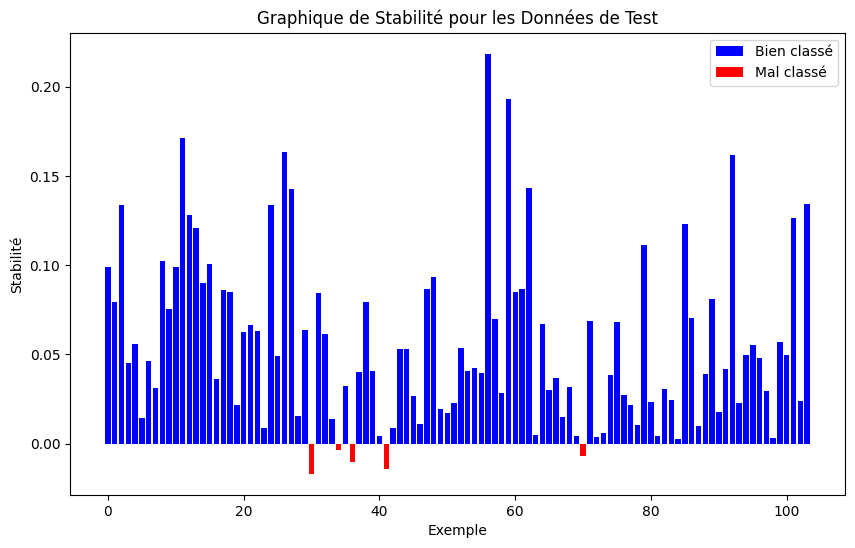

In [252]:
train_test_df = pd.concat([train_df, test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Séparation des caractéristiques et des étiquettes
train_test_features = train_test_df.iloc[:, :-1].values
train_test_labels = train_test_df.iloc[:, -1].values

# Entraînement du perceptron
train_test_weights = perceptron_batch(train_test_features, train_test_labels,22000,0.001)


# # Convertir les étiquettes de l'ensemble de test en valeurs numériques -1 et 1
# # test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
# # Séparer les caractéristiques et les étiquettes de l'ensemble de test
# test_features = test_df.iloc[:, :-1].values
# test_labels = test_df.iloc[:, -1].values

# Calculer la précision sur l'ensemble d'entraînement et de test
train_accuracy = calculate_accuracy(train_test_features, train_test_labels, train_test_weights)
test_accuracy = calculate_accuracy(test_features, test_labels, train_test_weights)

# Calculer les erreurs d'apprentissage (Ea) et de généralisation (Eg)
Ea = 1 - train_accuracy
Eg = 1 - test_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")

print("Les poids du perceptron",train_test_weights)

# Calcul des stabilités pour l'ensemble de test
test_stabilities_L = calculate_stability(test_features, test_labels, train_test_weights)

# Afficher les stabilités des exemples de test
print(test_stabilities_L)

plot_stability(test_stabilities_L)






Early Stopping

In [254]:
import numpy as np
import pandas as pd

# Supposons que vos données sont déjà chargées dans train_df et test_df.
# Nous allons concaténer ces ensembles et les mélanger pour former l'ensemble L.
train_test_df = train_test_df.sample(frac=1, random_state=1).reset_index(drop=True)

# Fonction d'entraînement de perceptron avec arrêt prématuré
def perceptron_batch_avec_ES(features, labels, validation_features, validation_labels, epochs, learning_rate, patience):
    weights = np.zeros(features.shape[1] + 1)
    best_weights = None
    meilleur_validation_accuracy = 0
    patience_counter = 0
    early_stop_epoch = 0  

    for epoch in range(epochs):
        update = np.zeros(features.shape[1] + 1)
        for inputs, label in zip(features, labels):
            activation = np.dot(inputs, weights[1:]) + weights[0]
            prediction = 1 if activation >= 0 else -1
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        weights += update

        # Évaluer la précision sur l'ensemble de validation
        validation_accuracy = calculate_accuracy(validation_features, validation_labels, weights)

        # Mettre à jour les meilleurs poids si l'exactitude sur l'ensemble de validation s'améliore
        if validation_accuracy > meilleur_validation_accuracy:
            meilleur_validation_accuracy = validation_accuracy
            meilleur_weights = weights.copy()
            patience_counter = 0
            early_stop_epoch = epoch
        else:
            patience_counter += 1

        # Si la patience est dépassée, arrêter l'entraînement
        if patience_counter >= patience:
            break

    return meilleur_weights if meilleur_weights is not None else weights, early_stop_epoch

# Répéter l'expérience et collecter les statistiques
num_experiments = 5
errors_train = []
errors_validation = []
errors_test = []
early_stop_epochs = []

for _ in range(num_experiments):
    train_test_df = train_test_df.sample(frac=1, random_state=1).reset_index(drop=True)
    # Diviser l'ensemble L en LA, LV, LT
    LA_df, remaining_df = np.split(train_test_df, [int(.5*len(train_test_df))])
    LV_df, LT_df = np.split(remaining_df, [int(.5*len(remaining_df))])

    # Convertir en matrices numpy
    LA_features, LA_labels = LA_df.iloc[:, :-1].values, LA_df.iloc[:, -1].values
    LV_features, LV_labels = LV_df.iloc[:, :-1].values, LV_df.iloc[:, -1].values
    LT_features, LT_labels = LT_df.iloc[:, :-1].values, LT_df.iloc[:, -1].values

    # Entraînement avec arrêt prématuré
    best_weights, stop_epoch = perceptron_batch_avec_ES(LA_features, LA_labels, LV_features, LV_labels,
                                                        epochs=22000, learning_rate=0.001, patience=2000)
    early_stop_epochs.append(stop_epoch)

    # Calcul des erreurs
    errors_train.append(1 - calculate_accuracy(LA_features, LA_labels, best_weights))
    errors_validation.append(1 - calculate_accuracy(LV_features, LV_labels, best_weights))
    errors_test.append(1 - calculate_accuracy(LT_features, LT_labels, best_weights))

# Calculer la moyenne des erreurs
mean_error_train = np.mean(errors_train)
mean_error_validation = np.mean(errors_validation)
mean_error_test = np.mean(errors_test)

print(f"Erreur moyenne d'apprentissage (Ea): {mean_error_train}")
print(f"Erreur moyenne de validation (Ev): {mean_error_validation}")
print(f"Erreur moyenne de test (Et): {mean_error_test}")

mean_early_stop_epoch = np.mean(early_stop_epochs)
print(f"Epoch moyenne d'arrêt prématuré : {mean_early_stop_epoch}")


Erreur moyenne d'apprentissage (Ea): 0.14807692307692308
Erreur moyenne de validation (Ev): 0.20769230769230768
Erreur moyenne de test (Et): 0.23076923076923078
Epoch moyenne d'arrêt prématuré : 606.2
